In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from typing import *
import numpy as np
from functools import partial
from fastprogress import progress_bar
import pandas as pd
import h5py

from lumin.plotting.results import plot_roc

import torch
from torch import Tensor, nn
import torch.nn.functional as F
from torch._vmap_internals import _vmap as vmap

from tomopt.volume import *
from tomopt.muon import *
from tomopt.inference import *
from tomopt.optimisation import *
from tomopt.core import *
from tomopt.utils import *
from tomopt.plotting import *

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
DEVICE = torch.device("cpu")

In [4]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x)

In [7]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.9
    init_res = 1e4
    n_panels = 4
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,1-(i*(2*size)/n_panels)], init_xy_span=[2.,2.],
                                                       device=DEVICE) for i in range(n_panels)]))
    for z in [0.8,0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,0.2-(i*(2*size)/n_panels)], init_xy_span=[2.,2.],
                                                       device=DEVICE) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [8]:
volume = Volume(get_layers())

In [7]:
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.]), and xy span tensor([2., 2.])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9500]), and xy span tensor([2., 2.])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9000]), and xy span tensor([2., 2.])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8500]), and xy span tensor([2., 2.])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.2000]),

In [9]:
from tomopt.benchmarks import ULorryPassiveGenerator

In [11]:
u_volume = 1
passive_gen = ULorryPassiveGenerator(volume, u_volume=u_volume, u_prob=0.5, fill_frac=0.8, x0_lorry=X0['iron'], bkg_materials=['air', 'iron'])

In [12]:
test_passives = PassiveYielder(passive_gen, n_passives=200)

In [13]:
from tomopt.optimisation import NoMoreNaNs, PanelMetricLogger, CostCoefWarmup, PanelOptConfig, MuonResampler

In [16]:
wrapper = PanelVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xy_span_opt=partial(torch.optim.SGD, lr=1e4),
                             loss_func=VolumeClassLoss(x02id={0:0, 1:1}, target_budget=5),
                             partial_volume_inferrer=partial(DenseBlockClassifierFromX0s, n_block_voxels=u_volume, partial_x0_inferer=PanelX0Inferrer, volume=volume, ratio_offset=-1, ratio_coef=1))

In [13]:
from sklearn.metrics import roc_auc_score

def get_roc_auc(preds:List[Tuple[np.ndarray,np.ndarray]], n=1000) -> Tuple[float, float]:
    scores = []
    preds = np.array(preds, dtype=object).flatten().reshape(-1,2)
    for _ in range(n):
        rpreds = preds[np.random.choice(np.arange(len(preds)), len(preds), replace=True)]
        if len(np.unique(rpreds[:,1])) == 2:  # Avoid single class in sampling
            scores.append(roc_auc_score(y_true=rpreds[:,1].astype(int), y_score=rpreds[:,0]))
    return np.mean(scores), np.std(scores, ddof=1)

In [65]:
np.arange(50, 1000, 50)

array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650,
       700, 750, 800, 850, 900, 950])

In [69]:
df = pd.DataFrame()
for n in progress_bar(np.arange(50, 1000, 50)):
    preds = wrapper.predict(test_passives,
                n_mu_per_volume=n,
                mu_bs=50,
                pred_cb=ClassPredHandler(x02id={0:0, 1:1}),
                cbs=[MuonResampler()])
    df = df.append([(n, *get_roc_auc(preds))])
    df.to_csv('muon_bs_data.csv')

In [69]:
df = pd.DataFrame()
for n in progress_bar(np.arange(50, 1000, 50)):
    preds = wrapper.predict(test_passives,
                n_mu_per_volume=n,
                mu_bs=50,
                pred_cb=ClassPredHandler(x02id={0:0, 1:1}),
                cbs=[MuonResampler()])
    df = df.append([(n, *get_roc_auc(preds))])
    df.to_csv('muon_bs_data.csv')

In [73]:
df.columns = ['n_muons', 'roc_auc', 'roc_auc_unc']

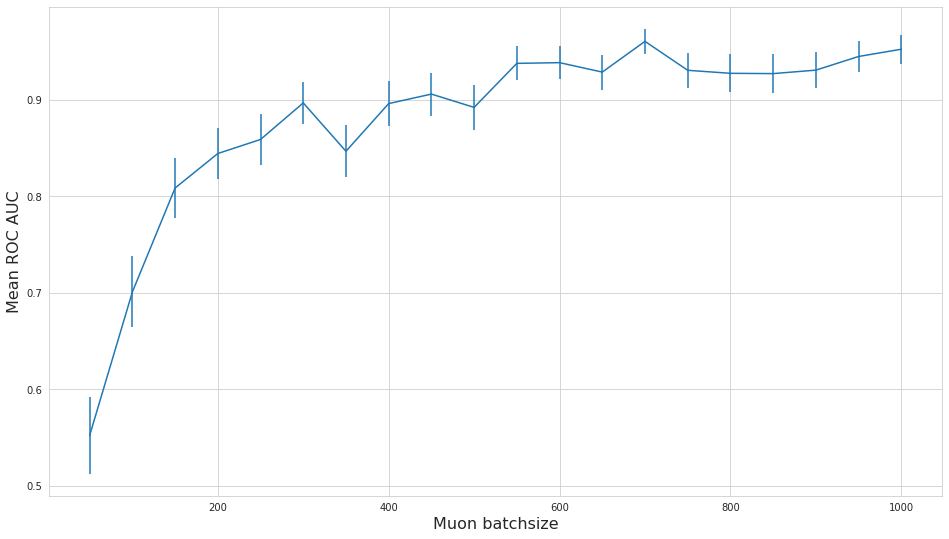

In [79]:
with sns.axes_style(**{'style':'whitegrid', 'rc':{'patch.edgecolor':'none'}}):
    plt.figure(figsize=(16,9))
    plt.errorbar(df.n_muons, df.roc_auc, yerr=df.roc_auc_unc)
    plt.ylabel('Mean ROC AUC', fontsize=16)
    plt.xlabel('Muon batchsize', fontsize=16)